In [2]:
%matplotlib inline

## [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html) (SVMs)
- Used for classification, regression & outlier detection.
- Advantages:
    - Good for high-D problems.
    - Good when #dimensions >> #samples.
    - Uses a subset of training points in the decision function = memory efficient.
    - Can use a variety of [kernel functions](https://scikit-learn.org/stable/modules/svm.html) for the decision function. Standard & custom functions can be used.
- Disadvantages:
    - Subject to overfitting if #features >> #samples.
    - Does not provide probability estimates. (These must be generated using cross-validation).
- Supports both dense and sparse data. Use C-ordered numpy.ndarray or scipy.sparse.csr_matrix datatypes with dtype=float64.
- Complexity increases **rapidly** with the number of training vectors. The [libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) based quadratic solver needs $O(n_{features} \times n_{samples}^2)$ to $O(n_{features} \times n_{samples}^3)$ depending on libsvm cache efficiency - which is dataset-dependent.
- **LinearSVC** instead uses [liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) which is much more efficient. It scales linearly to very large datasets.

## SVM Classification
- Three methods: 
    - [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
    - [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC)
    - [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) - assumes using a linear kernel. Faster.
- All three methods use X = training array (#samples, #features) and y = class labels (#samples, strings or integers)

In [3]:
from sklearn import svm
X = [[0, 0], [1, 1]]
y = [0, 1]
clf = svm.SVC()
clf.fit(X, y)
clf.predict([[2.0,2.0]])

array([1])

- The decision function depends on "support vectors" (a subset of the training data). Attributes:

In [4]:
print(clf.support_vectors_)
# indices of support vectors
print(clf.support_)
# number of support vectors for each class
print(clf.n_support_)

[[0. 0.]
 [1. 1.]]
[0 1]
[1 1]


## Example: SVM classifier (binary, linear kernel)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

[numpy.meshgrid](https://numpy.org/doc/1.18/reference/generated/numpy.meshgrid.html)
[numpy.vstack](https://numpy.org/doc/1.18/reference/generated/numpy.vstack.html)
[numpy.reshape](https://numpy.org/doc/1.18/reference/generated/numpy.reshape.html)
[numpy.ravel](https://numpy.org/devdocs/reference/generated/numpy.ravel.html)

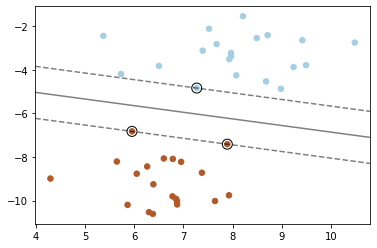

In [9]:
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot decision function. gca = "get current axes"
ax   = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx     = np.linspace(xlim[0], xlim[1], 30)
yy     = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy     = np.vstack([XX.ravel(), 
                    YY.ravel()]).T
Z      = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, 
           colors='k', levels=[-1, 0, 1], 
           alpha=0.5,
           linestyles=['--', '-', '--'])

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], 
           clf.support_vectors_[:, 1], 
           s=100, linewidth=1, 
           facecolors='none', edgecolors='k')
plt.show()

- SVMs build one or more hyperplanes for classification or regression tasks. A "good" hyperplane has a largest distance between the nearest training data point (ie, "functional margin").
- Above: 3 samples are on the margin boundries (ie, "support vectors"

## Example: SVM classifier (binary, non-linear), RBF kernel 

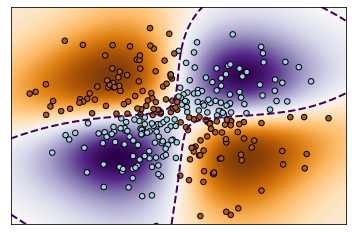

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
clf = svm.NuSVC(gamma='auto')
clf.fit(X, Y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), 
                   xx.max(), 
                   yy.min(), 
                   yy.max()), 
           aspect='auto',
           origin='lower', 
           cmap=plt.cm.PuOr_r)

contours = plt.contour(xx, yy, Z, 
                       levels=[0], 
                       linewidths=2,
                       linestyles='dashed')

plt.scatter(X[:, 0], X[:, 1], 
            s=30, c=Y, 
            cmap=plt.cm.Paired,
            edgecolors='k')

plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

## Example: SVM classifier with univariate feature selection preprocessing (to improve scoring)
- iris dataset (4 features) + 36 non-useful features

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [12]:
np.random.seed(0)
X, y = load_iris(return_X_y=True)
X    = np.hstack((X, 2 * np.random.random((X.shape[0], 36))))
print(X)

[[5.1        3.5        1.4        ... 1.1368679  0.0375796  1.23527099]
 [4.9        3.         1.4        ... 0.19219682 1.95291893 0.9373024 ]
 [4.7        3.2        1.3        ... 1.15231467 1.18408386 1.14450381]
 ...
 [6.5        3.         5.2        ... 0.8168546  1.4421851  1.87060082]
 [6.2        3.4        5.4        ... 0.20947559 0.22710621 0.83360661]
 [5.9        3.         5.1        ... 0.25893904 0.03081289 0.77348467]]


In [13]:
# feature selector + scaler + SVM classifier
clf = Pipeline([('anova',  SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc',    SVC(gamma="auto"))])

In [14]:
# Plot CV score vs % of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

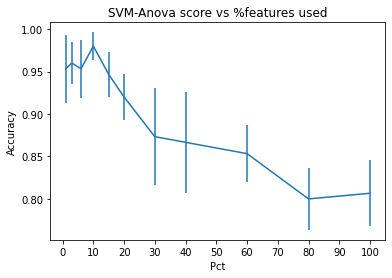

In [15]:
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'SVM-Anova score vs %features used')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Pct')
plt.ylabel('Accuracy')
plt.axis('tight')
plt.show()

## SVM Classification (Multiclass)
- SVC, NuSVC use "one vs all" approach.
    - (nclasses * nclasses-1)/2 classifiers are built
    - each trained from two classes
    - ```decision_function_shape``` - transforms results from "one vs one" classifier to "one vs rest" decision function of shape (nsamples, nclasses)

In [16]:
X = [[0], [1], [2], [3]]
Y = [0, 1, 2, 3]
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, Y)

dec = clf.decision_function([[1]])
print(dec.shape[1]) # 4 classes: 4*3/2 = 6

clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
print(dec.shape[1]) # 4 classes


6
4


- LinearSVC uses "one vs rest" strategy - trains nclasses models

In [17]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X, Y)

dec = lin_clf.decision_function([[1]])
print(dec.shape[1])

4


- LinearSVC also supports the "Crammer & Singer" multiclass algorithm via ```multi_class="crammer_singer"```. Improved runtime.

## Comparison: SVM Classifier algorithms - iris dataset
- 2D projection of iris dataset
- only using 1st two features (length, width)
- plot decision surfaces for 4 classifiers w/ different kernels.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

In [19]:
# x,y: meshgrid x-axis, y-axis
# h: stepsize (opt)
# returns xx,yy (ndarrays)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [20]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [21]:
iris = datasets.load_iris()
X,y  = iris.data[:,:2], iris.target
C    = 1.0 # regularization

models = (svm.SVC(      kernel='linear', C=C),
          svm.LinearSVC(                 C=C, max_iter=10000),
          svm.SVC(      kernel='rbf',    C=C, gamma  = 0.7),
          svm.SVC(      kernel='poly',   C=C, gamma  = 'auto',
                                              degree = 3))

In [22]:
models = (clf.fit(X,y) for clf in models)

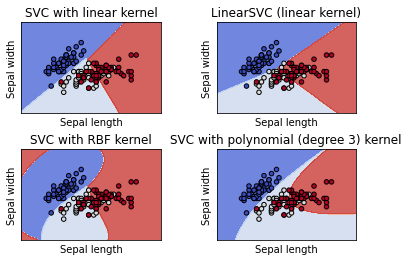

In [23]:
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, 
                  alpha=0.8)
    ax.scatter(X0, X1, c=y, 
               cmap=plt.cm.coolwarm, 
               s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Classifier Scoring
- ```decision_function``` returns per-class scores for each sample.
- if ```probability=True```, you also get class membership probability estimates. 
- Binary classifiers use **Platt scaling** which includes cross-validation. This can be expensive for large datasets.

## Example: SVM Tie Breakers
- Costly when ```decision_function="ovr"```, so it's not enabled by default.
- When ```decision_function="ovr"``` and ```n_classes>2```, the ```predict``` method doesn't break ties unless directed to by ```break_ties=True```. Otherwise the 1st class among ties will be returned.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

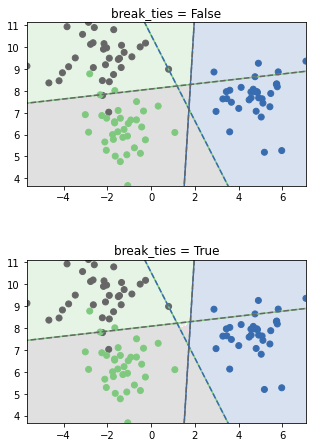

In [25]:
X, y = make_blobs(random_state=27)

fig, sub = plt.subplots(2, 1, figsize=(5, 8))
titles = ("break_ties = False",
          "break_ties = True")

for break_ties, title, ax in zip((False, True), 
                                 titles, 
                                 sub.flatten()):

    svm = SVC(kernel="linear", 
              C=1, 
              break_ties=break_ties,
              decision_function_shape='ovr').fit(X, y)

    xlim = [X[:, 0].min(), X[:, 0].max()]
    ylim = [X[:, 1].min(), X[:, 1].max()]

    xs     = np.linspace(xlim[0], xlim[1], 1000)
    ys     = np.linspace(ylim[0], ylim[1], 1000)
    xx, yy = np.meshgrid(xs, ys)
    pred   = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    colors = [plt.cm.Accent(i) for i in [0, 4, 7]]
    points = ax.scatter(X[:, 0], 
                        X[:, 1], 
                        c=y, cmap="Accent")
    
    classes = [(0, 1), (0, 2), (1, 2)]
    line    = np.linspace(X[:, 1].min() - 5, 
                          X[:, 1].max() + 5)
    
    ax.imshow(-pred.reshape(xx.shape), 
              cmap="Accent", alpha=.2,
              extent=(xlim[0], xlim[1], 
                      ylim[1], ylim[0]))

    for coef, intercept, col in zip(svm.coef_, 
                                    svm.intercept_, 
                                    classes):
        line2 = -(line * coef[1] + intercept) / coef[0]
        ax.plot(line2, line, "-", c=colors[col[0]])
        ax.plot(line2, line, "--", c=colors[col[1]])
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_aspect("equal")

plt.show()

## SVM Classification - Unbalanced Classes
- **SVC** uses ```class_weight``` in the ```fit``` method. It's a dictionary of ```{class_label : value}``` with value being a float > 0 that sets parameter ```C``` of a class label to ```C*value```.

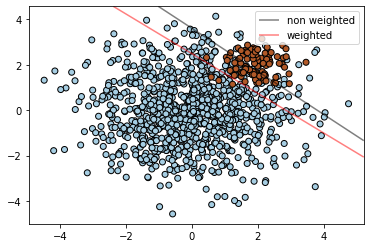

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

# we create two clusters of random points
n_samples_1, n_samples_2 = 1000,100
centers                  = [[0.0, 0.0], 
                            [2.0, 2.0]]
clusters_std              = [1.5, 0.5]

X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

clf  = svm.SVC(kernel='linear', C=1.0)
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
clf.fit(X, y)
wclf.fit(X, y)

plt.scatter(X[:, 0], 
            X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

# plot both decision functions
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx     = np.linspace(xlim[0], xlim[1], 30)
yy     = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy     = np.vstack([XX.ravel(), 
                    YY.ravel()]).T
Z      = clf.decision_function(xy).reshape(XX.shape)

a = ax.contour(XX, YY, Z, 
               colors='k', levels=[0], 
               alpha=0.5, linestyles=['-'])

Z = wclf.decision_function(xy).reshape(XX.shape)

b = ax.contour(XX, YY, Z, 
               colors='r', levels=[0], 
               alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], 
            b.collections[0]], 
           ["non weighted", "weighted"],
           loc="upper right")

plt.show()

## SVM Classification - Weighted Samples
- Point size = proportional to weight
- Sample weighting rescales C
- Outliers get extra weighting to highlight decision boundary deformation.

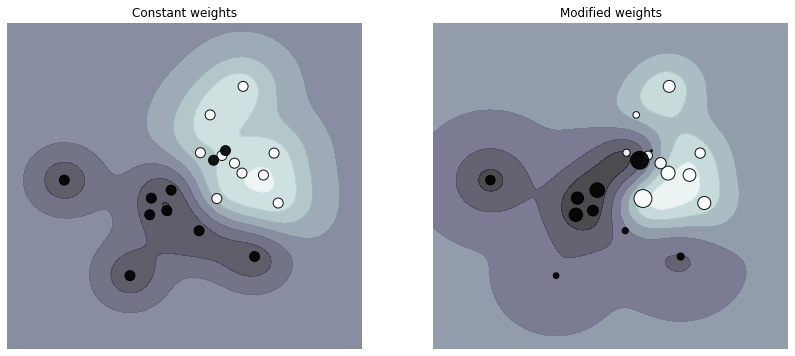

In [27]:
def plot_decision_function(classifier, sample_weight, axis, title):

    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), 
                         np.linspace(-4, 5, 500))

    Z = classifier.decision_function(
        np.c_[xx.ravel(), 
              yy.ravel()])
    Z = Z.reshape(xx.shape)

    axis.contourf(xx, yy, Z, 
                  alpha=0.75, cmap=plt.cm.bone)
    
    axis.scatter(X[:, 0], 
                 X[:, 1], c=y, 
                 s=100 * sample_weight, 
                 alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)

# create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], 
          np.random.randn(10, 2)]
y = [1]*10 + [-1]*10

sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9]   *= 15

# for reference, first fit without sample weights
# fit the model
clf_weights    = svm.SVC(gamma=1)
clf_no_weights = svm.SVC(gamma=1)

clf_weights.fit(   X, y, sample_weight = sample_weight_last_ten)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, 
                       sample_weight_constant, 
                       axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, 
                       sample_weight_last_ten, 
                       axes[1],
                       "Modified weights")
plt.show()

## Support Vector Regression
- Same three method types:
    - [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)
    - [NuSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR)
    - [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR) - faster; linear kernel only.

In [28]:
from sklearn import svm
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
regr = svm.SVR()
regr.fit(X, y)

regr.predict([[1, 1]])


array([1.5])

## Example: SVR, 1D (linear/polynomial/RBF kernels)

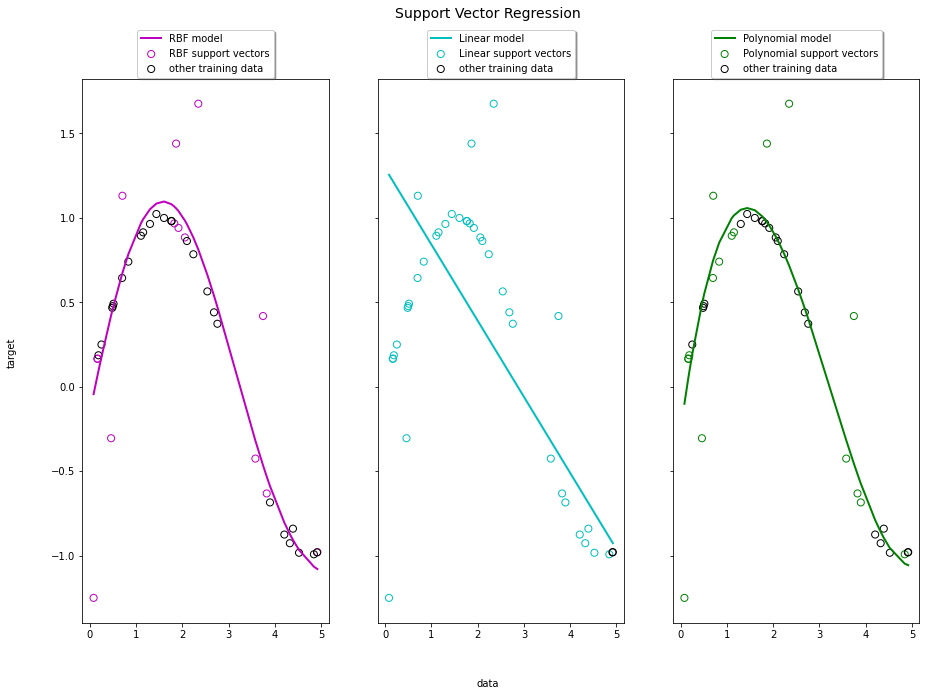

In [30]:
from sklearn.svm import SVR
# Generate sample data with noise
X       = np.sort(5 * np.random.rand(40, 1), axis=0)
y       = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8))

svr_rbf  = SVR(kernel='rbf',    C=100, gamma   = 0.1, 
                                       epsilon = 0.1)
svr_lin  = SVR(kernel='linear', C=100, gamma = 'auto')
svr_poly = SVR(kernel='poly',   C=100, gamma = 'auto', 
                                       epsilon = 0.1,
                                       degree = 3, 
                                       coef0 = 1)

lw = 2

svrs         = [svr_rbf, svr_lin,  svr_poly]
kernel_label = ['RBF',   'Linear', 'Polynomial']
model_color  = ['m',     'c',      'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), 
                         sharey=True)

for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), 
                  color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    
    axes[ix].scatter(X[svr.support_], 
                     y[svr.support_], 
                     facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), 
                                    svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), 
                                    svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    
    axes[ix].legend(loc='upper center', 
                    bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5,  0.04, 'data',  ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', 
                                         rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

## SVM and Outlier Detection
- See [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM).
- See [SKLearn User Guide on Novelty & Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection)

## Best Practices
- **Kernel Cache Size**: strong impact on run times. Set ```cache_size``` to a higher value such as 500 (MB) or 1000 (MB) if memory allows. Default is 200 (MB).
- **C (regularization)**: 1.0 by default; usually OK. Consider decreasing it if you have noisy data. Linear kernels (SVR, SVC) are less sensitive to large C - predictions stop improving after awhile. Larger values of C take more time to train.
- **Scaling your data**: HIGHLY recommended. SVM algos are not scale invariant. Best done with a pipeline:

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC())

## Standard Kernels
- linear: $\langle x, x'\rangle$
- polynomial: $(\gamma \langle x, x'\rangle + r)^d$ - $d$ specified by ```degree```, r by ```coef0```.
- rbf: $\exp(-\gamma \|x-x'\|^2)$ - $\gamma$ specified by ```gamma``` (>0).
- sigmoid: $\tanh(\gamma \langle x,x'\rangle + r)$ - r specified by ```coef0```.

- ```C``` is common to all SVM kernels & trades misclassification for decision surface simplicity. (Low C = smooth surface; high C = minimizes classification training errors.)
- ```gamma``` defines amount of influence from a single training sample. (larger gamma = other samples to be affected must be closer.)
- Use [grid search cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) with ```C``` and ```gamma``` spaced expoentially apart for best results.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# utility - moves colormap midpoint to values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

In [33]:
iris = load_iris()
X = iris.data
y = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)


In [34]:
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))


The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


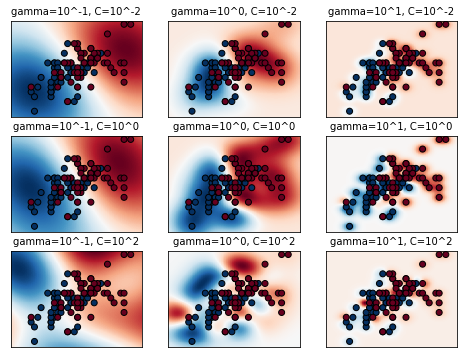

In [35]:
# viz: parameter effects
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

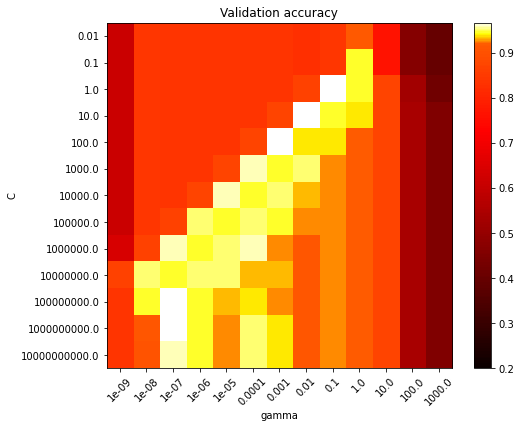

In [36]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## Custom Kernels

In [39]:
import numpy as np
from sklearn import svm
def my_kernel(X, Y):
    return np.dot(X, Y.T)

clf = svm.SVC(kernel=my_kernel)

## Custom Kernel - Example

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target
#print(X,Y)

In [47]:
def my_kernel(X,Y):
    M = np.array([[2, 0], [0, 1.0]])
    return np.dot(np.dot(X, M), Y.T)

h = .02  # step size in the mesh

clf = svm.SVC(kernel=my_kernel)
#clf.fit(X, Y)

In [38]:

# Plot the decision boundary.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy       = np.meshgrid(np.arange(x_min, x_max, h), 
                           np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), 
                      yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot training points
plt.scatter(X[:, 0], 
            X[:, 1], c=Y, 
            cmap=plt.cm.Paired, edgecolors='k')
plt.title('SVC, custom kernel, 3 classes')
plt.axis('tight')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [150, 4]

## Custom Pre-computed kernels (Gram matrix)
- Specify pre-computed kernels using ```kernel='precomputed'```. 
- You then pass a Gram matrix (instead of X) to ```fit``` and ```predict```.

In [48]:
import numpy as np
from sklearn.datasets        import make_classification
from sklearn.model_selection import train_test_split
from sklearn                 import svm

X, y = make_classification(n_samples=10, 
                           random_state=0)
X_train , X_test , y_train, y_test = train_test_split(
    X, y, random_state=0)

clf = svm.SVC(kernel='precomputed')

# linear kernel computation
gram_train = np.dot(X_train, X_train.T)
clf.fit(gram_train, y_train)

# predict on training examples
gram_test = np.dot(X_test, X_train.T)
clf.predict(gram_test)

array([0, 1, 0])